In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from timm.scheduler import CosineLRScheduler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")
import json
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes
import gc
import os
import torch.jit as jit
import torch.autograd as autograd
import random 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
device

'cuda'

In [3]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv


In [6]:
df_train = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
df_train

date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1         0     0  
2         0     0  
3         1     0  
4         2     0  
...     ...   ...  
43795     0     0  
43796     0     0  
43797     0     0  
43798     0     0  
43799     0     0  

[43800 rows x 9 columns]

In [7]:
df_train = df_train.drop(columns = ["date"])

In [8]:
df_test = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
df_test

dew  temp  press wnd_dir  wnd_spd  snow  rain  pollution
0    -16     4   1027      SE     3.58     0     0        128
1    -17     5   1027      SE     7.60     0     0         77
2    -16     4   1027      SE     9.39     0     0         65
3    -16     1   1028      cv     0.89     0     0         79
4    -14     0   1028      NE     1.79     0     0         93
..   ...   ...    ...     ...      ...   ...   ...        ...
341  -23    -2   1034      NW   231.97     0     0          8
342  -22    -3   1034      NW   237.78     0     0         10
343  -22    -3   1034      NW   242.70     0     0         10
344  -22    -4   1034      NW   246.72     0     0          8
345  -21    -3   1034      NW   249.85     0     0         12

[346 rows x 8 columns]

In [9]:
def cleaning(data: pd.DataFrame)->pd.DataFrame:
    print("before cleaning data")
    print(data.isna().sum())
    print("len of data is: ",len(data))
    
    print("after cleaning data")
    data.dropna()
    print(data.isna().sum())
    print("len of data is: ",len(data))
    return data
df_train = cleaning(df_train)

before cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800
after cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800


In [10]:
def view_data(data:pd.DataFrame)->None:
    #set subploannotationst parameters
    n_col = 2
    columns =  data.columns.tolist()
    
    #Create a subplot for each variable
    fig = make_subplots(rows =len(columns)//2,cols = n_col, subplot_titles = columns)
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']
    
    #counter for plot figure
    counts = 0
    
    #plot figures
    for col_color in zip (columns, colors):
        row = (counts >> 1) +1
        col = (counts & 1) +1
        fig.add_trace(go.Histogram(x=data[col_color[0]], nbinsx=20, marker_color=col_color[1]), row=row, col=col)
        
        #set x and y title
        fig.update_xaxes(title_text = 'value', row = row, col = col)
        fig.update_yaxes(title_text = 'Frequency', row = row, col = col)
        
        counts +=1
    #update layout and set set subplot title size
    fig.update_layout(height=1000, width=1200, title_text='Distribution of Variables', showlegend=False)
    fig.update_annotations(font_size=16)    
    
    fig.show()
    return
    
view_data(df_train)

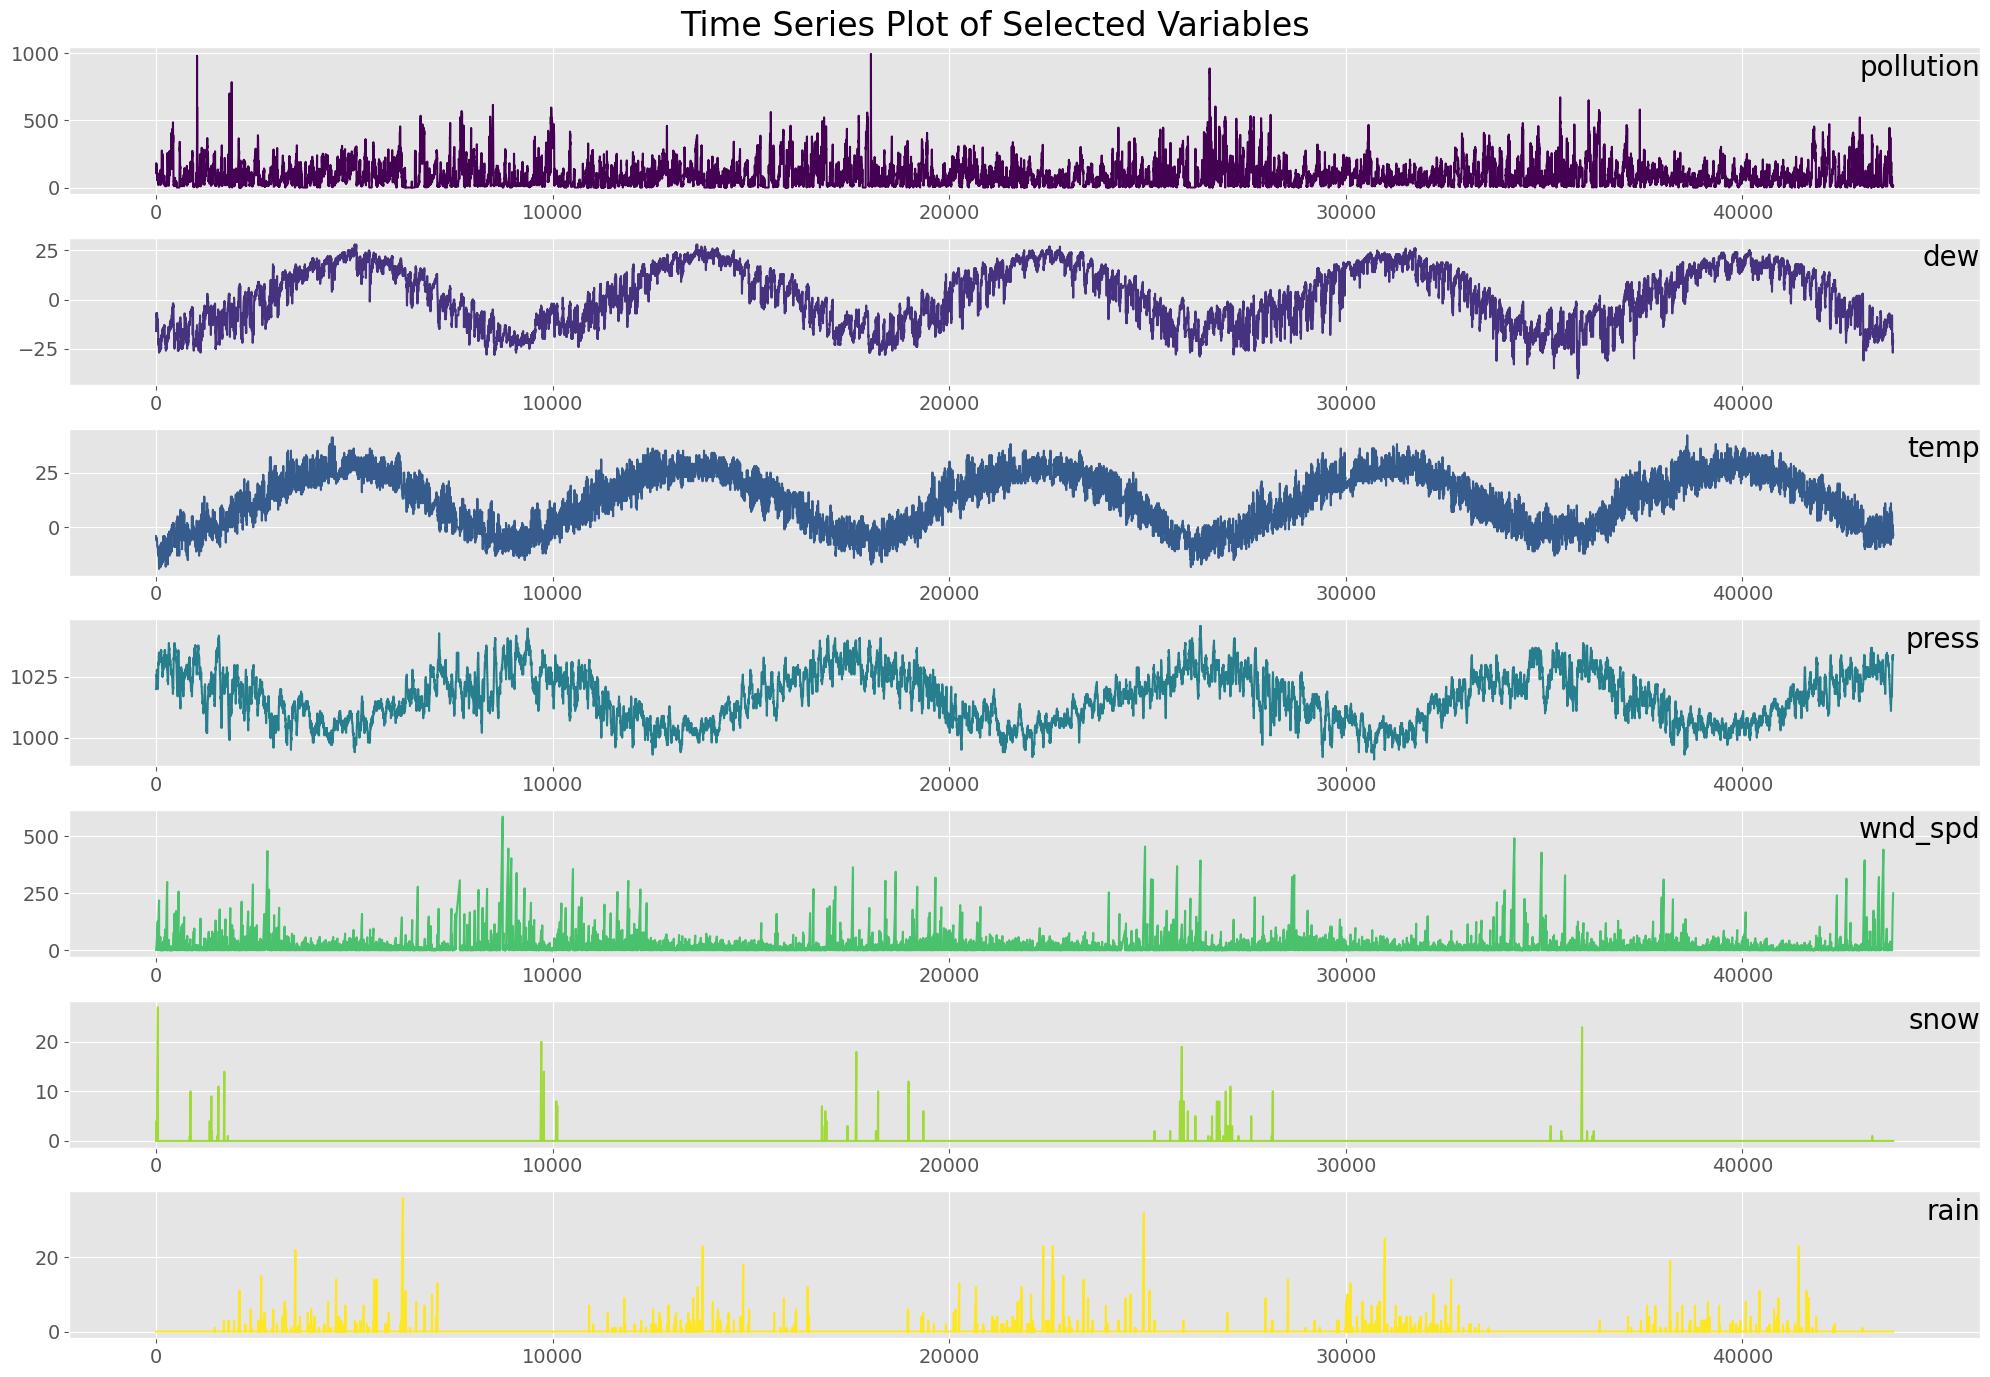

In [11]:
#plot time series figures

def view_timeseries(data:pd.DataFrame)->None:
    groups = [0,1,2,3,5,6,7]
    values = data.values
    fig, axes = plt.subplots(len(groups), 1, figsize=(20,14), facecolor = "white")
    for group, ax in zip(groups, axes):
        ax.plot(values[:, group], color=cm.viridis(group/len(groups)))
        ax.set_title(data.columns[group], y=0.75, loc='right', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.grid(True)
        
    plt.suptitle('Time Series Plot of Selected Variables', fontsize=24)
    plt.tight_layout()
    plt.show()
    
    return

view_timeseries(df_train)

In [12]:
df_train = df_train.drop(columns = ["snow"])
df_test = df_test.drop(columns = ["snow"])

In [13]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
catogorical_columns = df_train.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[catogorical_columns])
train_encoded = encoder.transform(df_train[catogorical_columns])
test_encoded = encoder.transform(df_test[catogorical_columns])

train_encoded_df = pd.DataFrame(train_encoded, columns = encoder.get_feature_names_out(catogorical_columns))
test_encoded_df = pd.DataFrame(test_encoded, columns = encoder.get_feature_names_out(catogorical_columns))

df_train = pd.concat([df_train, train_encoded_df], axis = 1)
df_test = pd.concat([df_test, test_encoded_df], axis = 1)

df_train = df_train.drop(catogorical_columns, axis = 1)
df_test = df_test.drop(catogorical_columns, axis = 1)

df_test

dew  temp  press  wnd_spd  rain  pollution  wnd_dir_NE  wnd_dir_NW  \
0    -16     4   1027     3.58     0        128         0.0         0.0   
1    -17     5   1027     7.60     0         77         0.0         0.0   
2    -16     4   1027     9.39     0         65         0.0         0.0   
3    -16     1   1028     0.89     0         79         0.0         0.0   
4    -14     0   1028     1.79     0         93         1.0         0.0   
..   ...   ...    ...      ...   ...        ...         ...         ...   
341  -23    -2   1034   231.97     0          8         0.0         1.0   
342  -22    -3   1034   237.78     0         10         0.0         1.0   
343  -22    -3   1034   242.70     0         10         0.0         1.0   
344  -22    -4   1034   246.72     0          8         0.0         1.0   
345  -21    -3   1034   249.85     0         12         0.0         1.0   

     wnd_dir_SE  wnd_dir_cv  
0           1.0         0.0  
1           1.0         0.0  
2           1.0         0.0  
3           0.0         1.0  
4           0.0         0.0  
..          ...         ...  
341         0.0         0.0  
342         0.0         0.0  
343         0.0         0.0  
344         0.0         0.0  
345         0.0         0.0  

[346 rows x 10 columns]

In [14]:
# # df_train_scaled = df_train.copy()
# # df_test_scaled = df_test.copy()

# # Define the mapping dictionary
# mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# # Replace the string values with numerical values
# df_train['wnd_dir'] = df_train['wnd_dir'].map(mapping)
# df_test['wnd_dir'] = df_test['wnd_dir'].map(mapping)

# # df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# # Resetting the index
# # df_train_scaled.set_index('date', inplace=True)
# df_train.head()

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #defualt is (0,1)

cols = [i for i in range(5)]
columns = df_train.columns[cols].tolist()

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train

pollution       dew      temp     press   wnd_spd  rain  wnd_dir_NE  \
0       0.129779  0.352941  0.245902  0.527273  0.002290     0         0.0   
1       0.148893  0.367647  0.245902  0.527273  0.003811     0         0.0   
2       0.159960  0.426471  0.229508  0.545455  0.005332     0         0.0   
3       0.182093  0.485294  0.229508  0.563636  0.008391     0         0.0   
4       0.138833  0.485294  0.229508  0.563636  0.009912     0         0.0   
...          ...       ...       ...       ...       ...   ...         ...   
43795   0.008048  0.250000  0.278689  0.781818  0.395659     0         0.0   
43796   0.010060  0.264706  0.262295  0.781818  0.405588     0         0.0   
43797   0.010060  0.264706  0.262295  0.781818  0.413996     0         0.0   
43798   0.008048  0.264706  0.245902  0.781818  0.420866     0         0.0   
43799   0.012072  0.279412  0.262295  0.781818  0.426216     0         0.0   

       wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         1.0         0.0  
1             0.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         1.0         0.0  
4             0.0         1.0         0.0  
...           ...         ...         ...  
43795         1.0         0.0         0.0  
43796         1.0         0.0         0.0  
43797         1.0         0.0         0.0  
43798         1.0         0.0         0.0  
43799         1.0         0.0         0.0  

[43800 rows x 10 columns]

In [16]:
train_size = int(len(df_train) * 0.8)
num_epochs = 150
steps = train_size*num_epochs
warmup_steps = int(steps*0.2)
train= df_train.iloc[:train_size, :]
val = df_train.iloc[train_size:, :]
train

pollution       dew      temp     press   wnd_spd  rain  wnd_dir_NE  \
0       0.129779  0.352941  0.245902  0.527273  0.002290     0         0.0   
1       0.148893  0.367647  0.245902  0.527273  0.003811     0         0.0   
2       0.159960  0.426471  0.229508  0.545455  0.005332     0         0.0   
3       0.182093  0.485294  0.229508  0.563636  0.008391     0         0.0   
4       0.138833  0.485294  0.229508  0.563636  0.009912     0         0.0   
...          ...       ...       ...       ...       ...   ...         ...   
35035   0.022133  0.308824  0.426230  0.400000  0.195540     0         0.0   
35036   0.018109  0.279412  0.426230  0.418182  0.203948     0         0.0   
35037   0.023139  0.279412  0.426230  0.418182  0.213877     0         0.0   
35038   0.020121  0.279412  0.409836  0.418182  0.222285     0         0.0   
35039   0.023139  0.294118  0.426230  0.418182  0.234504     0         0.0   

       wnd_dir_NW  wnd_dir_SE  wnd_dir_cv  
0             0.0         1.0         0.0  
1             0.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         1.0         0.0  
4             0.0         1.0         0.0  
...           ...         ...         ...  
35035         1.0         0.0         0.0  
35036         1.0         0.0         0.0  
35037         1.0         0.0         0.0  
35038         1.0         0.0         0.0  
35039         1.0         0.0         0.0  

[35040 rows x 10 columns]

In [17]:
window_size = 11#24*7

# TrainSet
X_sequences = []
y_values = []

n_past = 11
n_future = 1

for i in range(n_past, len(train) - n_future+1):
    X_seq = train.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = train.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# ValidSet
X_sequences = []
y_values = []

for i in range(n_past, len(val) - n_future+1):
    X_seq = val.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = val.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_valid = np.array(X_sequences)
y_valid = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(n_past, len(df_test) - n_future+1):
    X_seq = df_test.iloc[ i- n_past:i].drop(columns=["pollution"]).values
    Y_val = df_test.iloc[i + n_future - 1:i + n_future]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(35029, 11, 9)
(35029, 1)
--------------------test_data---------------------
(335, 11, 9)
(335, 1)


In [18]:
# # Calculating mean and standard deviation for standardization of features in the training set
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()

# # Standardizing features in the training and validation sets based on the training set statistics
# X_train = (X_train - X_train_mean) / X_train_std
# X_valid = (X_valid - X_train_mean) / X_train_std

# # Calculating mean and standard deviation for standardization of target values in the training set
# y_train_mean = y_train.mean()
# y_train_std = y_train.std()

# # Standardizing target values in the training and validation sets based on the training set statistics
# y_train = (y_train - y_train_mean) / y_train_std
# y_valid = (y_valid - y_train_mean) / y_train_std
# X_test = (X_test - X_train_mean) / X_train_std
# y_test = (y_test - y_train_mean) / y_train_std

In [19]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

In [20]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# use_cuda = torch.cuda.is_available()

In [21]:
# if torch.cuda.is_available():
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

In [22]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_size,use_cuda,dropout = 0.2, bidir=True):
        
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.use_gpu = use_cuda
        self.lstm = nn.LSTM(input_size=hidden_size,dropout=dropout, hidden_size=hidden_size, bidirectional=bidir)
        self.fc1 = nn.Linear(
            hidden_size * 2, hidden_size
        )
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size * 2*2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        

#         x = F.normalize(x,dim=0)
          # log probabilities + hidden states

    def init_hidden(self,batch_size):
        # first is the hidden h
        # second is the cell c
        if self.use_gpu:
            return (autograd.Variable(torch.zeros(2, batch_size, self.hidden_size).cuda()),
                    autograd.Variable(torch.zeros(2, batch_size, self.hidden_size).cuda()))
        else:
            return (Variable(torch.zeros(2, batch_size, self.hidden_size)),
                    Variable(torch.zeros(2, batch_size, self.hidden_size)))

    def forward(self, x):
        batch_size = x[0].size(0)
        self.hidden = self.init_hidden(batch_size)
#         x = x.transpose(0,1)
        lstm, self.hidden = self.lstm(x, self.hidden)
        lstm = self.fc1(lstm)
        lstm = self.ln1(lstm)
        lstm = nn.functional.relu(lstm)
#         lstm = self.fc2(lstm)
#         lstm = self.ln2(lstm)
#         lstm = nn.functional.relu(lstm)
#         y = self.fc_out(lstm[:,-1,:])
        
        return lstm

In [23]:
class mutiBiLSTM(nn.Module):
    def __init__(self, input_size,hidden_size, out_size,n_layers,use_cuda,dropout = 0.2, bidir=True):
        
        super(mutiBiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers
        
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.mutibilstm = nn.ModuleList(
            [
                BiLSTM(hidden_size,use_cuda = use_cuda,dropout = dropout ,bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)
        
    def forward(self, x ):
        
        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)
        for i, lstm in enumerate(self.mutibilstm):
            x = lstm(x)
        x = self.fc_out(x[:, -1, :])
        return x
        

In [24]:
from timm.scheduler import CosineLRScheduler


model = mutiBiLSTM(input_size=9,hidden_size=16,out_size=1,n_layers=3 ,use_cuda=use_cuda,bidir=True ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 0)


steps = train_size*num_epochs
scheduler = CosineLRScheduler(optimizer,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, last_epoch=-1, verbose=False,)
criterion = nn.MSELoss()

print(model)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



mutiBiLSTM(
  (fc_in): Linear(in_features=9, out_features=16, bias=True)
  (ln): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (mutibilstm): ModuleList(
    (0-2): 3 x BiLSTM(
      (lstm): LSTM(16, 16, dropout=0.2, bidirectional=True)
      (fc1): Linear(in_features=32, out_features=16, bias=True)
      (ln1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (fc2): Linear(in_features=64, out_features=16, bias=True)
      (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
)


In [25]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

val_set = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=1,
                          shuffle=True,
                          drop_last=True,
                          )

In [26]:
# seed = 3407
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [27]:
next(model.parameters()).is_cuda

True

In [28]:
import copy
model_path = '/kaggle/working/'
history = {
    "train_loss": [],
    "valid_loss": [],
    "valid_mAP": [],
    "lr": [],
}
best_valid_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

In [29]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "16x3_loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

#     plt.figure()
#     plt.plot(epochs, history["lr"])
#     plt.title("Learning Rate evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("LR")
#     plt.savefig(os.path.join(model_path, "lr_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 0, train_avg_loss: 0.008682090891235707


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 0, val_avg_loss: 0.00882791701854367


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 1, train_avg_loss: 0.00828911120117126


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 1, val_avg_loss: 0.00869640493646073


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 2, train_avg_loss: 0.008015868012023787


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 2, val_avg_loss: 0.00847788981414458


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 3, train_avg_loss: 0.0075013517979719765


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 3, val_avg_loss: 0.007282301143064222


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 4, train_avg_loss: 0.006587486465225742


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 4, val_avg_loss: 0.00675610611863407


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 5, train_avg_loss: 0.006198320533123405


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 5, val_avg_loss: 0.006534613503463867


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 6, train_avg_loss: 0.006092015463157371


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 6, val_avg_loss: 0.00658372499563837


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 7, train_avg_loss: 0.006032987817303811


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 7, val_avg_loss: 0.006601178100513424


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 8, train_avg_loss: 0.005997573249842256


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 8, val_avg_loss: 0.0066191346833189


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 9, train_avg_loss: 0.0059442095267177785


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 9, val_avg_loss: 0.006629376683295483


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 10, train_avg_loss: 0.0059658799108059934


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 10, val_avg_loss: 0.006223689848744744


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 11, train_avg_loss: 0.00592784700409545


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 11, val_avg_loss: 0.006432764802721667


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 12, train_avg_loss: 0.005934741265664875


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 12, val_avg_loss: 0.006683510337570757


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 13, train_avg_loss: 0.005889293916269769


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 13, val_avg_loss: 0.006183441294248014


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 14, train_avg_loss: 0.005899716826910034


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 14, val_avg_loss: 0.0062594788687153555


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 15, train_avg_loss: 0.005912453323088491


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 15, val_avg_loss: 0.006545355870139413


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 16, train_avg_loss: 0.005903395425938615


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 16, val_avg_loss: 0.006838606566449989


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 17, train_avg_loss: 0.005860117346242452


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 17, val_avg_loss: 0.0063655950046304765


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 18, train_avg_loss: 0.005846918371469429


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 18, val_avg_loss: 0.006275876321157802


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 19, train_avg_loss: 0.005851133780594799


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 19, val_avg_loss: 0.006192403894528446


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 20, train_avg_loss: 0.005813118584868643


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 20, val_avg_loss: 0.0063104897514906725


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 21, train_avg_loss: 0.005814295529193794


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 21, val_avg_loss: 0.006326182756484265


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 22, train_avg_loss: 0.005814767767840373


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 22, val_avg_loss: 0.0061192163534892294


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 23, train_avg_loss: 0.00579640234674121


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 23, val_avg_loss: 0.0063012741692023075


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 24, train_avg_loss: 0.005802341139240282


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 24, val_avg_loss: 0.006172831840608474


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 25, train_avg_loss: 0.00580485554972163


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 25, val_avg_loss: 0.006173488342854785


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 26, train_avg_loss: 0.005735778177014026


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 26, val_avg_loss: 0.006578866623072534


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 27, train_avg_loss: 0.005736143194701713


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 27, val_avg_loss: 0.006928992323788913


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 28, train_avg_loss: 0.0057589277688718625


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 28, val_avg_loss: 0.006523356923915364


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 29, train_avg_loss: 0.005739392854507001


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 29, val_avg_loss: 0.00635796085583394


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 30, train_avg_loss: 0.005725487896093973


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 30, val_avg_loss: 0.006284615200613335


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 31, train_avg_loss: 0.0056984412590922


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 31, val_avg_loss: 0.006321396108123136


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 32, train_avg_loss: 0.005670396454135974


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 32, val_avg_loss: 0.006199088261032907


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 33, train_avg_loss: 0.005670746780614414


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 33, val_avg_loss: 0.006035695279753961


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 34, train_avg_loss: 0.00563742431864769


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 34, val_avg_loss: 0.0063529422795809394


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 35, train_avg_loss: 0.0056365477723551325


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 35, val_avg_loss: 0.005980960015828411


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 36, train_avg_loss: 0.005630407205713024


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 36, val_avg_loss: 0.006301913953696688


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 37, train_avg_loss: 0.0056078134627520725


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 37, val_avg_loss: 0.006435766051124249


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 38, train_avg_loss: 0.005601592962413011


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 38, val_avg_loss: 0.006600594547178064


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 39, train_avg_loss: 0.005599197558398908


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 39, val_avg_loss: 0.006225838423143704


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 40, train_avg_loss: 0.005586242578328644


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 40, val_avg_loss: 0.0059950019760848785


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 41, train_avg_loss: 0.005577984193941813


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 41, val_avg_loss: 0.006372530298177904


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 42, train_avg_loss: 0.005581216430129787


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 42, val_avg_loss: 0.006067386262064233


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 43, train_avg_loss: 0.0055668069005235556


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 43, val_avg_loss: 0.006167821078254217


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 44, train_avg_loss: 0.0055470770323679695


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 44, val_avg_loss: 0.006357980753046088


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 45, train_avg_loss: 0.005560735395834552


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 45, val_avg_loss: 0.006205101772944951


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 46, train_avg_loss: 0.005546734559135188


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 46, val_avg_loss: 0.006392144175474924


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 47, train_avg_loss: 0.005532668170394032


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 47, val_avg_loss: 0.006381918360639513


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 48, train_avg_loss: 0.005523338016327743


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 48, val_avg_loss: 0.006640060509268481


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 49, train_avg_loss: 0.005528745577407582


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 49, val_avg_loss: 0.006378782215449727


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 50, train_avg_loss: 0.005518018389039824


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 50, val_avg_loss: 0.00627200965575137


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 51, train_avg_loss: 0.0054997894599041145


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 51, val_avg_loss: 0.006245488957194918


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 52, train_avg_loss: 0.005502566265200233


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 52, val_avg_loss: 0.0060628803707863934


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 53, train_avg_loss: 0.00549935919632352


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 53, val_avg_loss: 0.006185120508508013


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 54, train_avg_loss: 0.005474263780888245


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 54, val_avg_loss: 0.0061536128236144615


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 55, train_avg_loss: 0.005464422957604782


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 55, val_avg_loss: 0.0060177105803029


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 56, train_avg_loss: 0.005455891747313673


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 56, val_avg_loss: 0.006286437373314967


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 57, train_avg_loss: 0.005449717215490502


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 57, val_avg_loss: 0.006091814624630051


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 58, train_avg_loss: 0.005441000458437071


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 58, val_avg_loss: 0.006121534084894391


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 59, train_avg_loss: 0.005435121058555783


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 59, val_avg_loss: 0.006046831279041266


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 60, train_avg_loss: 0.0054197309015597975


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 60, val_avg_loss: 0.0061647018269318475


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 61, train_avg_loss: 0.005414952396098491


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 61, val_avg_loss: 0.006454318758414124


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 62, train_avg_loss: 0.0054009162059600315


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 62, val_avg_loss: 0.006039254069277137


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 63, train_avg_loss: 0.005383369460501036


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 63, val_avg_loss: 0.006027788441498583


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 64, train_avg_loss: 0.005397675013879631


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 64, val_avg_loss: 0.006058604497421574


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 65, train_avg_loss: 0.0053811565749611115


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 65, val_avg_loss: 0.006146733523704684


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 66, train_avg_loss: 0.005362396347951536


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 66, val_avg_loss: 0.006045820896390948


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 67, train_avg_loss: 0.0053565161011328195


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 67, val_avg_loss: 0.006047504059390435


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 68, train_avg_loss: 0.005352484818907213


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 68, val_avg_loss: 0.0060018504259343715


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 69, train_avg_loss: 0.005335191485873837


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 69, val_avg_loss: 0.006071694404221116


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 70, train_avg_loss: 0.0053217863684036585


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 70, val_avg_loss: 0.006223804777106032


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 71, train_avg_loss: 0.005311681066109361


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 71, val_avg_loss: 0.006192066195854174


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 72, train_avg_loss: 0.005322597568456281


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 72, val_avg_loss: 0.005981784241850532


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 73, train_avg_loss: 0.00530438753765611


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 73, val_avg_loss: 0.006028339413468873


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 74, train_avg_loss: 0.005302733557606951


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 74, val_avg_loss: 0.005932959743720844


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 75, train_avg_loss: 0.005285971901648537


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 75, val_avg_loss: 0.006357374974618574


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 76, train_avg_loss: 0.005291159657299199


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 76, val_avg_loss: 0.0059935017390818


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 77, train_avg_loss: 0.005291046952050677


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 77, val_avg_loss: 0.006057909689417225


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 78, train_avg_loss: 0.005271268953289156


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 78, val_avg_loss: 0.005930492322680441


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 79, train_avg_loss: 0.0052643029791365975


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 79, val_avg_loss: 0.0061498409752894344


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 80, train_avg_loss: 0.0052692174059773035


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 80, val_avg_loss: 0.006062668690205494


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 81, train_avg_loss: 0.0052563476746976786


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 81, val_avg_loss: 0.00594714108595263


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 82, train_avg_loss: 0.005243635366941501


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 82, val_avg_loss: 0.005918565519229124


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 83, train_avg_loss: 0.005228373592900763


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 83, val_avg_loss: 0.005918497779157572


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 84, train_avg_loss: 0.005227784245016165


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 84, val_avg_loss: 0.006060100610848967


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 85, train_avg_loss: 0.005219376224588596


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 85, val_avg_loss: 0.0061731692864099045


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 86, train_avg_loss: 0.005220532668005314


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 86, val_avg_loss: 0.00608571319825497


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 87, train_avg_loss: 0.005206894879297471


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 87, val_avg_loss: 0.005958105383727413


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 88, train_avg_loss: 0.005215303538413122


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 88, val_avg_loss: 0.0060774641330678


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 89, train_avg_loss: 0.005196826033408275


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 89, val_avg_loss: 0.006026289876100126


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 90, train_avg_loss: 0.005184933665366861


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 90, val_avg_loss: 0.006154055022736909


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 91, train_avg_loss: 0.00516681160060161


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 91, val_avg_loss: 0.006252422813460872


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 92, train_avg_loss: 0.005173690476832772


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 92, val_avg_loss: 0.006118680844288115


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 93, train_avg_loss: 0.005157495799352682


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 93, val_avg_loss: 0.005969891753627649


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 94, train_avg_loss: 0.005167602211849039


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 94, val_avg_loss: 0.005908584903632274


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 95, train_avg_loss: 0.005150958924840326


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 95, val_avg_loss: 0.006263799464753096


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 96, train_avg_loss: 0.005150297318582663


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 96, val_avg_loss: 0.005891805489960334


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 97, train_avg_loss: 0.005132819647580246


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 97, val_avg_loss: 0.006135004468947895


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 98, train_avg_loss: 0.00513264934585125


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 98, val_avg_loss: 0.00605189469352965


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 99, train_avg_loss: 0.00512065752794612


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 99, val_avg_loss: 0.006100666005635164


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 100, train_avg_loss: 0.005120215966652269


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 100, val_avg_loss: 0.006190836754535417


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 101, train_avg_loss: 0.0051233908164713335


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 101, val_avg_loss: 0.00590971140822075


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 102, train_avg_loss: 0.005095774839484087


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 102, val_avg_loss: 0.005961874076045859


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 103, train_avg_loss: 0.0050905697855168795


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 103, val_avg_loss: 0.005986153426999738


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 104, train_avg_loss: 0.0050866523411949


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 104, val_avg_loss: 0.005984655595060452


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 105, train_avg_loss: 0.005074729383059044


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 105, val_avg_loss: 0.005908651180196922


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 106, train_avg_loss: 0.005078190477510448


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 106, val_avg_loss: 0.005959267052139528


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 107, train_avg_loss: 0.005063826565311922


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 107, val_avg_loss: 0.006047790466241484


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 108, train_avg_loss: 0.005061229487555017


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 108, val_avg_loss: 0.006087892857250577


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 109, train_avg_loss: 0.005047909338372016


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 109, val_avg_loss: 0.00592054966999211


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 110, train_avg_loss: 0.005039375812437562


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 110, val_avg_loss: 0.005934554283104619


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 111, train_avg_loss: 0.005043817179871747


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 111, val_avg_loss: 0.005972866890883762


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 112, train_avg_loss: 0.005043041952685632


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 112, val_avg_loss: 0.005991942171628277


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 113, train_avg_loss: 0.005026081780191354


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 113, val_avg_loss: 0.006056633605638812


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 114, train_avg_loss: 0.005023686769371597


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 114, val_avg_loss: 0.0059723594531266785


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 115, train_avg_loss: 0.005017814523233118


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 115, val_avg_loss: 0.006002122539713051


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 116, train_avg_loss: 0.005012106107610876


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 116, val_avg_loss: 0.006029949579797276


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 117, train_avg_loss: 0.004998707753881536


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 117, val_avg_loss: 0.005966976050444411


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 118, train_avg_loss: 0.005002126711147447


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 118, val_avg_loss: 0.006004215346055699


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 119, train_avg_loss: 0.004987634913578725


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 119, val_avg_loss: 0.005998327580174848


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 120, train_avg_loss: 0.004991095582912021


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 120, val_avg_loss: 0.005943858451482878


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 121, train_avg_loss: 0.004989781013223423


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 121, val_avg_loss: 0.006047340759823283


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 122, train_avg_loss: 0.004977476960486499


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 122, val_avg_loss: 0.0059772920393941055


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 123, train_avg_loss: 0.004978898676113145


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 123, val_avg_loss: 0.00605505127280664


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 124, train_avg_loss: 0.0049729507567166905


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 124, val_avg_loss: 0.0059948919508128595


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 125, train_avg_loss: 0.004963664195187035


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 125, val_avg_loss: 0.006015796422866265


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 126, train_avg_loss: 0.0049643098994203326


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 126, val_avg_loss: 0.0059730256835148834


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 127, train_avg_loss: 0.004955026627794058


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 127, val_avg_loss: 0.005960651597045635


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 128, train_avg_loss: 0.0049564785917180585


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 128, val_avg_loss: 0.005991818056264449


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 129, train_avg_loss: 0.004949283016223284


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 129, val_avg_loss: 0.0059916744291809675


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 130, train_avg_loss: 0.004946376052851085


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 130, val_avg_loss: 0.00600217966296311


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 131, train_avg_loss: 0.004948174290638247


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 131, val_avg_loss: 0.005995636801627693


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 132, train_avg_loss: 0.004946040556982323


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 132, val_avg_loss: 0.006009639555080061


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 133, train_avg_loss: 0.004936397680076319


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 133, val_avg_loss: 0.006013365219783843


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 134, train_avg_loss: 0.004931363747055068


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 134, val_avg_loss: 0.005975117657893088


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 135, train_avg_loss: 0.004931045556632492


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 135, val_avg_loss: 0.0059908022144604675


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 136, train_avg_loss: 0.004919725170693576


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 136, val_avg_loss: 0.005966117918992845


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 137, train_avg_loss: 0.00492425525149797


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 137, val_avg_loss: 0.006001986061724333


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 138, train_avg_loss: 0.004918300139358509


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 138, val_avg_loss: 0.006005509101935823


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 139, train_avg_loss: 0.004914336242556395


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 139, val_avg_loss: 0.006007397803648515


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 140, train_avg_loss: 0.00491961814702354


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 140, val_avg_loss: 0.005992203884785346


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 141, train_avg_loss: 0.004913902429159785


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 141, val_avg_loss: 0.00599516686410285


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 142, train_avg_loss: 0.004918078992120373


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 142, val_avg_loss: 0.005991361813104606


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 143, train_avg_loss: 0.00491306677060985


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 143, val_avg_loss: 0.005987778715806375


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 144, train_avg_loss: 0.004912445489066045


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 144, val_avg_loss: 0.005994365178304468


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 145, train_avg_loss: 0.004922116427810886


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 145, val_avg_loss: 0.005991748988290655


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 146, train_avg_loss: 0.004918645968470446


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 146, val_avg_loss: 0.0059917475964239506


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 147, train_avg_loss: 0.00491123146348134


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 147, val_avg_loss: 0.005996739510156814


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 148, train_avg_loss: 0.004902881787508008


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 148, val_avg_loss: 0.005994108147346056


train:   0%|          | 0/1094 [00:00<?, ?batch/s]

Epoch: 149, train_avg_loss: 0.004912706893605692


Eval:   0%|          | 0/273 [00:00<?, ?batch/s]

Epoch: 149, val_avg_loss: 0.006011767857008692


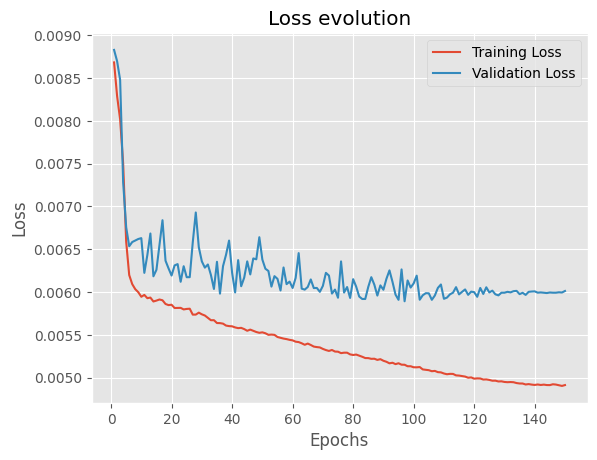

In [30]:
train_losses = []  # To store train losses
test_losses = []   # To store test losses

for epoch in range(num_epochs):
    model.to(device)
    model.train()
    train_loss = 0.0
    i = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="train", unit="batch")):
        # h = None
        # c = None
        inputs = inputs.reshape(-1, window_size, 9).to(device)
        targets = targets.reshape(-1, 1).to(device)
        # inputs = inputs.to(device)
        # targets = targets.to(device)
        outputs = model(inputs)
        # h = [hi.detach() for hi in h[0]]
        # c = [hi.detach() for hi in h[1]]
        optimizer.zero_grad()
        scheduler.step(i+train_size*epoch)
        loss = criterion(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # print(scheduler.get_last_lr())
    train_loss = (train_loss)/len(train_loader)
    print(f'Epoch: {epoch}, train_avg_loss: {train_loss}')
    history["train_loss"].append(train_loss)
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader, desc="Eval", unit="batch")):
            # h = None
            inputs = inputs.reshape(-1, window_size, 9).to(device)
            targets = targets.reshape(-1, 1).to(device)
            # inputs = inputs.to(device)
            # targets = targets.to(device)
            outputs = model(inputs)
            # outputs,h = model(inputs, h)
            # h = [hi.detach() for hi in h]
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
        valid_loss = (valid_loss)/len(val_loader)
        print(f'Epoch: {epoch}, val_avg_loss: {valid_loss}')
    
        history["valid_loss"].append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                os.path.join(model_path, f"16x3_model_best.pth"),
            )

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "16x3_history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

In [31]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

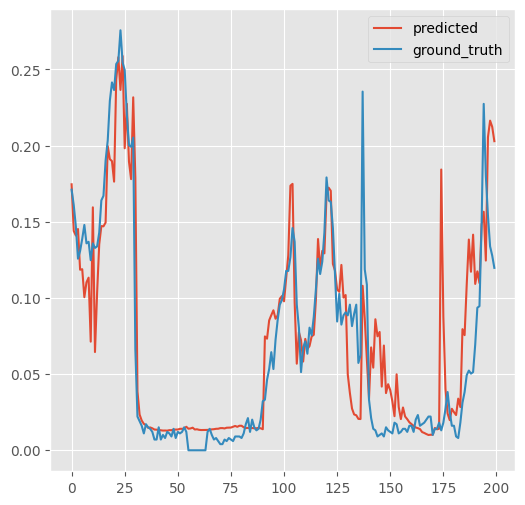

In [32]:
with torch.no_grad():
    # h = None
    predicted = model(X_test.to(device))
    # h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy()[:200], label='predicted')
plt.plot(y_test[:200], label='ground_truth')
plt.legend()
plt.show()